<a href="https://colab.research.google.com/github/andremanhas/Tech_Challenge/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Preços do Ibovespa




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

### Métricas de avaliação dos modelos

In [ ]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## 1. Coleta de Dados

In [ ]:
# Coletando Dados do Ibovespa

Total_data = pd.read_csv("Dados_Ibovespa.csv")
Total_data = Total_data[["Data","Último", "Abertura"]]
Total_data.reset_index(inplace=True)
Total_data["Data"] = pd.to_datetime(Total_data["Data"])
Total_data.rename(columns={"Data": "Date", "Último": "Close", "Abertura": "Open"}, inplace=True)


# Exibindo os primeiros registros
print(Total_data.head())

   index       Date    Close     Open
0      0 2024-07-29  126.954  127.492
1      1 2024-07-26  127.492  125.964
2      2 2024-07-25  125.954  126.423
3      3 2024-07-24  126.423  126.596
4      4 2024-07-23  126.590  127.860


<ipython-input-123-0a85df43b305>:6: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Total_data["Data"] = pd.to_datetime(Total_data["Data"])


In [ ]:
# Filtrando os dados para o período de 2015 a 2024
start_date = '2015-01-01'
end_date = '2024-07-29'
data = Total_data[(Total_data["Date"] >= start_date) & (Total_data["Date"] <= end_date)]


In [ ]:
print(data.head())

   index       Date    Close     Open
0      0 2024-07-29  126.954  127.492
1      1 2024-07-26  127.492  125.964
2      2 2024-07-25  125.954  126.423
3      3 2024-07-24  126.423  126.596
4      4 2024-07-23  126.590  127.860


In [ ]:
print(data.tail())

      index       Date   Close    Open
2368   2368 2015-01-08  49.943  49.463
2369   2369 2015-01-07  49.463  48.006
2370   2370 2015-01-06  48.001  47.517
2371   2371 2015-01-05  47.517  48.512
2372   2372 2015-01-02  48.512  50.004


## 2. Análise Exploratória dos Dados

### Visualização dos Dados

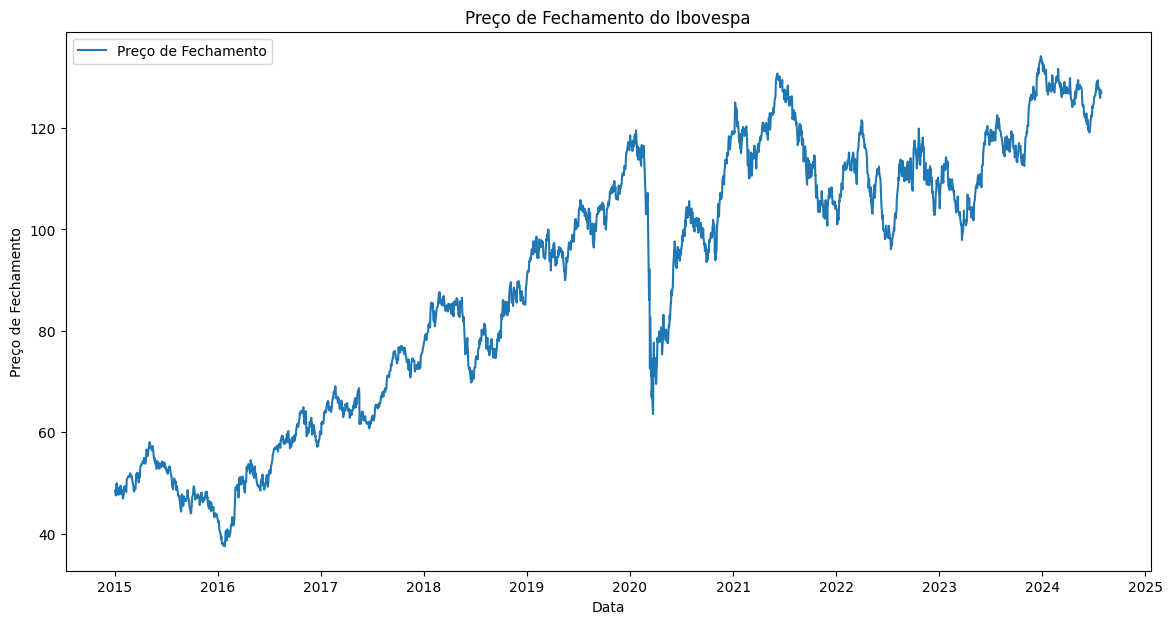

In [ ]:
# Visualização dos dados

plt.figure(figsize=(14, 7))
plt.plot(data["Date"], data["Close"], label="Preço de Fechamento")
plt.title("Preço de Fechamento do Ibovespa")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()

### Decomposição da Série Temporal

In [ ]:
result = seasonal_decompose(data["Close"], model="multiplicative", period=365)

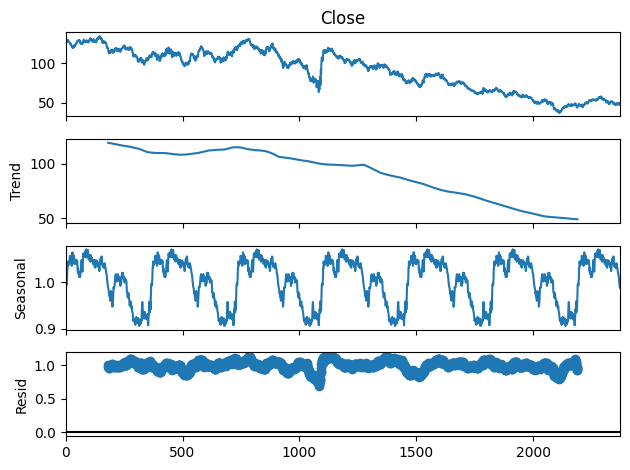

In [ ]:
# Decomposição da série temporal
result = seasonal_decompose(data["Close"], model="multiplicative", period=365)
result.plot()
plt.show()

<Axes: >

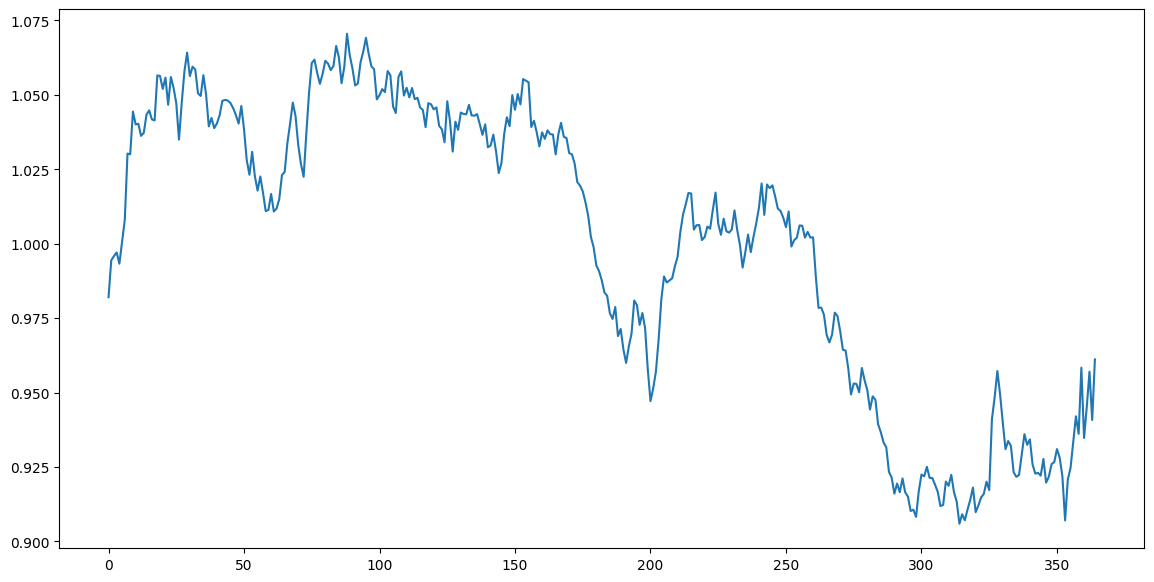

In [ ]:
result.seasonal.iloc[:365].plot(figsize=(14, 7))

### Estatísticas Descritivas

In [ ]:
# Estatísticas descritivas
data["Close"].describe()

count    2373.000000
mean       90.511432
std        26.408751
min        37.497000
25%        65.180000
50%        97.677000
75%       112.880000
max       134.194000
Name: Close, dtype: float64

### Verificação de Dados Ausentes

In [ ]:
# Verificação de dados ausentes

missing_values = data.isnull().sum()
missing_values

index    0
Date     0
Close    0
Open     0
dtype: int64

## 3. Preparação dos Dados e Modelagem

### Dividindo os Dados em Treino e Teste

In [ ]:
# Dividindo em treino e teste

train, test = data[7:], data[:7]


In [ ]:
train


,index,Date,Close,Open
7,7,2024-07-18,127.652,129.450
8,8,2024-07-17,129.450,129.112
9,9,2024-07-16,129.110,129.322
10,10,2024-07-15,129.321,128.898
11,11,2024-07-12,128.897,128.293
...,...,...,...,...
2368,2368,2015-01-08,49.943,49.463
2369,2369,2015-01-07,49.463,48.006
2370,2370,2015-01-06,48.001,47.517
2371,2371,2015-01-05,47.517,48.512


In [ ]:
test


,index,Date,Close,Open
0,0,2024-07-29,126.954,127.492
1,1,2024-07-26,127.492,125.964
2,2,2024-07-25,125.954,126.423
3,3,2024-07-24,126.423,126.596
4,4,2024-07-23,126.590,127.860
5,5,2024-07-22,127.860,127.616
6,6,2024-07-19,127.616,127.652


### Modelo Prophet

In [ ]:
# Modelo Prophet
train_prophet = train.rename(columns={"Date": "ds", "Close": "y"})
test_prophet = test.rename(columns={"Date": "ds", "Close": "y"})

model = Prophet(daily_seasonality=True)
model.add_regressor("Open")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Open"] = pd.concat([train["Open"], test["Open"]], ignore_index=True)
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvp4dgab8/342kr__o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvp4dgab8/maw1vj2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69331', 'data', 'file=/tmp/tmpvp4dgab8/342kr__o.json', 'init=/tmp/tmpvp4dgab8/maw1vj2d.json', 'output', 'file=/tmp/tmpvp4dgab8/prophet_modell276wtvv/prophet_model-20240730163248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Metrics:
MAE: 2.0598392161923504
MSE: 10.431084656100655
MAPE: 0.9321871935809587


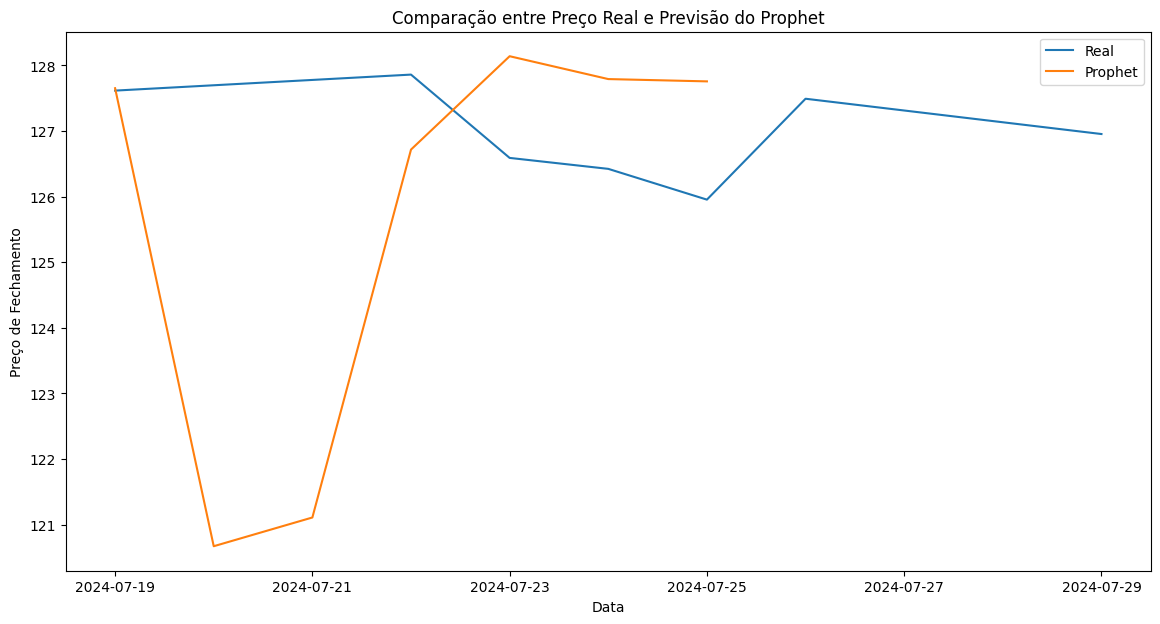

In [ ]:
# Plotando os resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label="Real")
plt.plot(preds["yhat"], label="Prophet")
plt.title("Comparação entre Preço Real e Previsão do Prophet")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()


### Modelo XGBoost

In [ ]:
# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df["dayofweek"] = df["Date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "Open"]
TARGET = "Close"

# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 0.7365048392159578
MSE: 1.326790528316909
MAPE: 0.5793675092452607


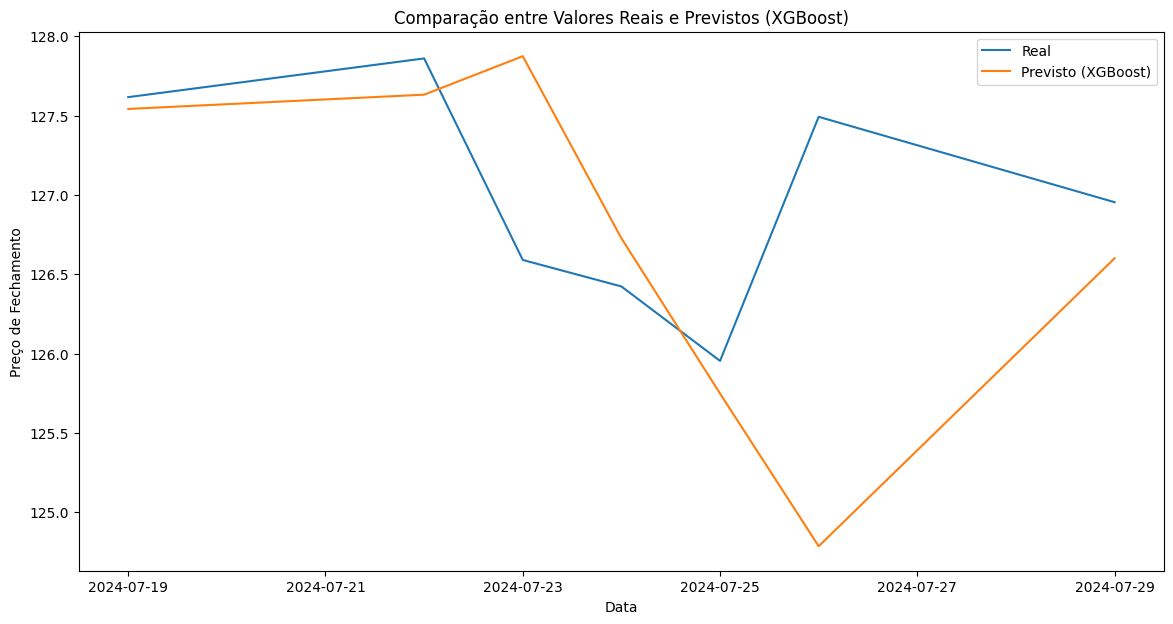

In [ ]:
# Gráfico comparando valores reais e previstos (XGBoost)
plt.figure(figsize=(14, 7))
plt.plot(test["Date"], y_test, label="Real")
plt.plot(test["Date"], preds, label="Previsto (XGBoost)")
plt.title("Comparação entre Valores Reais e Previstos (XGBoost)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()


### Modelo SARIMAX

# Comparando modelos

In [ ]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr],
    columns=["MAE", "MSE", "MAPE"],
    index=["Prophet", "XGBoost"],
)
df

,MAE,MSE,MAPE
Prophet,0.736505,1.326791,0.579368
XGBoost,2.059839,10.431085,0.932187


## Conclusão

Neste notebook foi realizada a analise dos dados de fechamento do Ibovespa desde 2015 ate o dia 29/07/2024. Foi realizada a modelagem dos dados utilizando os modelos Prophet e XG Boost. Ambos os modelos atingiram os prerequisitos do TechChallenge.

Prophet é um modelo de séries temporais desenvolvido pelo Facebook, projetado para lidar com dados de séries temporais que têm fortes componentes sazonais e tendências.

XGBoost é  uma técnica de aprendizado de máquina mais geral e poderosa que pode ser adaptada para séries temporais, mas requer engenharia de características e preparação extensiva dos dados. É mais versátil e pode lidar com vários tipos de dados além de séries temporais.

Os modelos apresentaram MAPE muito proximos (Prophet: 0.93 / XGBoost: 0.57),  de forma que a escolha por qual dos modelos  utilizar pode avaliar a demanda de recursos de processamento.

XGBoost normalmente requer mais recursos de processamento e memória, especialmente para grandes conjuntos de dados e modelos complexos. É mais intensivo devido à construção e otimização de múltiplas árvores de decisão e ao uso extensivo de paralelização.
Enquanto, o Prophet, é menos exigente em termos de recursos de processamento e memória. É otimizado para previsões de séries temporais e lida bem com grandes conjuntos de dados de forma eficiente.

Portanto, o Prophet pode ser a melhor escolha devido ao seu menor consumo de processamento e memória.
